In [1]:
import os
import pandas as pd
import numpy as np
import cv2

# Define the path to your dataset
dataset_path = 'dataset/'

# Define image size
image_size = (48, 48)

In [2]:
# Function to load images from a directory and convert to grayscale and resize
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if os.path.isfile(img_path):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale
            img = cv2.resize(img, image_size)  # Resize image
            img_flat = img.flatten()  # Flatten the image
            images.append(img_flat)
            labels.append(label)
    return images, labels

In [3]:
# Initialize lists to hold all images and labels
all_images = []
all_labels = []

# Loop through each folder (each folder represents a class)
for class_label in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_label)
    if os.path.isdir(class_path):
        images, labels = load_images_from_folder(class_path, class_label)
        all_images.extend(images)
        all_labels.extend(labels)

In [4]:
# Convert lists to arrays
all_images = np.array(all_images)
all_labels = np.array(all_labels)

# Create a DataFrame
df = pd.DataFrame(all_images)
df['label'] = all_labels

# Save DataFrame to CSV
df.to_csv('facial_expression_data.csv', index=False)

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

# Load the CSV file
df = pd.read_csv('facial_expression_data.csv')

# Separate the features and labels
data = df.drop(columns=['label']).values
labels = df['label'].values

# Create a mapping from class names to integers
class_names = np.unique(labels)
class_map = {name: idx for idx, name in enumerate(class_names)}
labels = np.array([class_map[label] for label in labels])

# Reshape the data to its original shape (135, 48, 48, 1)
data = data.reshape((-1, 48, 48, 1))

# One-hot encode the labels
num_classes = len(class_names)
labels = tf.keras.utils.to_categorical(labels, num_classes)

# Split the data: 70% training, 15% validation, 15% testing
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [6]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

In [7]:
# Define the model architecture
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(num_classes, activation='softmax')
])

In [8]:
# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [9]:
# Model checkpoint
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

In [10]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

In [11]:
# Train the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=8),
    epochs=50,
    validation_data=(X_val, y_val),
    # callbacks=[checkpoint]
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50
72/72 [==============================] - 38s 446ms/step - loss: 2.7554 - accuracy: 0.2404 - val_loss: 5.6292 - val_accuracy: 0.2033
Epoch 2/50
72/72 [==============================] - 28s 385ms/step - loss: 2.2178 - accuracy: 0.3223 - val_loss: 2.1710 - val_accuracy: 0.3902
Epoch 3/50
72/72 [==============================] - 26s 365ms/step - loss: 1.9043 - accuracy: 0.3868 - val_loss: 2.4799 - val_accuracy: 0.3902
Epoch 4/50
72/72 [==============================] - 27s 371ms/step - loss: 1.8572 - accuracy: 0.4233 - val_loss: 1.5950 - val_accuracy: 0.5122
Epoch 5/50
72/72 [==============================] - 26s 359ms/step - loss: 1.7981 - accuracy: 0.4094 - val_loss: 1.5414 - val_accuracy: 0.5122
Epoch 6/50
72/72 [==============================] - 27s 373ms/step - loss: 1.5874 - accuracy: 0.4895 - val_loss: 1.4552 - val_accuracy: 0.5122
Epoch 7/50
72/72 [==============================] - 21s 295ms/step - loss: 1.5185 - accuracy: 0.5000 - val_loss: 0.9225 - val_accuracy: 0.6423

In [12]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

4/4 [==============================] - 0s 62ms/step - loss: 0.5013 - accuracy: 0.8306
Test Accuracy: 83.06%


In [13]:
# Save the model
model.save('facial_expression_model.h5')

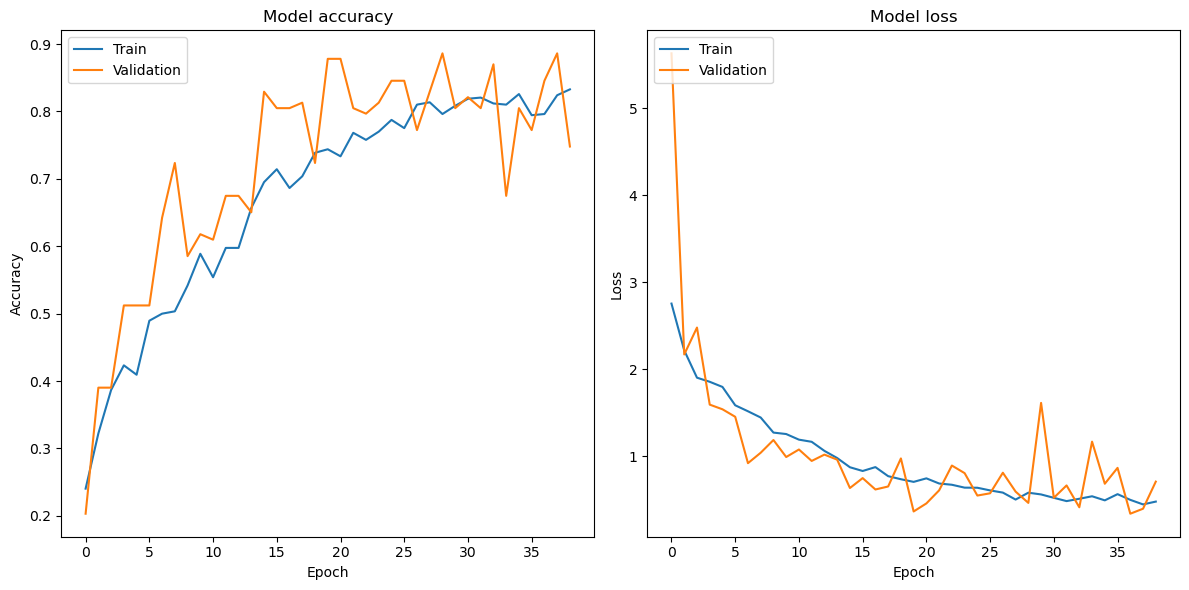

In [14]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

%%writefile run_app.py
from flask import Flask, request, jsonify, render_template, send_from_directory
import os
import base64
import cv2
import numpy as np
from tensorflow.keras.models import load_model

app = Flask(__name__)

# Load the trained model
model = load_model('facial_expression_model.h5')

# Define image size and class names
image_size = (48, 48)
class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Define the mapping for interested and not-interest
interested = ['happy', 'surprise', 'neutral']
not_interest = ['angry', 'sad', 'fear', 'disgust']

def process_image(image_data):
    # Decode the base64 image data
    img_data = base64.b64decode(image_data.split(',')[1])
    nparr = np.frombuffer(img_data, np.uint8)
    img = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, image_size)
    img = img.reshape((1, 48, 48, 1)) / 255.0
    
    # Predict the facial expression
    predictions = model.predict(img)
    class_idx = np.argmax(predictions)
    class_name = class_names[class_idx]
    
    return class_name

@app.route('/student_interface')
def student_interface():
    return render_template('student_interface.html')

@app.route('/process_image', methods=['POST'])
def process_image_route():
    data = request.json
    image_data = data['image']
    expression = process_image(image_data)
    
    # Save the image to the appropriate directory
    category = 'interested' if expression in interested else 'not-interest'
    directory = os.path.join('sorted_images', category, expression)
    os.makedirs(directory, exist_ok=True)
    img_count = len(os.listdir(directory))
    img_path = os.path.join(directory, f'image_{img_count + 1}.png')
    
    img_data = base64.b64decode(image_data.split(',')[1])
    with open(img_path, 'wb') as f:
        f.write(img_data)
    
    return jsonify({'status': 'success', 'expression': expression})

@app.route('/analytics')
def analytics():
    return render_template('analytics.html')

@app.route('/conductSession')
def conductSession():
    return render_template('conduct_session.html')

@app.route('/analytics_data')
def analytics_data():
    interested_count = sum([len(files) for r, d, files in os.walk('sorted_images/interested')])
    not_interest_count = sum([len(files) for r, d, files in os.walk('sorted_images/not-interest')])
    return jsonify({'interested_count': interested_count, 'not_interest_count': not_interest_count})

if __name__ == '__main__':
    app.run(debug=True)

In [2]:
%%writefile run_app.py
from flask import Flask, request, jsonify, render_template, send_from_directory
import os
import base64
import cv2
import numpy as np
from tensorflow.keras.models import load_model

app = Flask(__name__)

# Load the trained model
model = load_model('FER_model.h5')

# Define image size and class names
image_size = (48, 48)
class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Define the mapping for interested and not-interest
interested = ['happy', 'surprise', 'neutral']
not_interest = ['angry', 'sad', 'fear', 'disgust']

def process_image(image_data):
    # Decode the base64 image data
    img_data = base64.b64decode(image_data.split(',')[1])
    nparr = np.frombuffer(img_data, np.uint8)
    img = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, image_size)
    img = img.reshape((1, 48, 48, 1)) / 255.0
    
    # Predict the facial expression
    predictions = model.predict(img)
    class_idx = np.argmax(predictions)
    class_name = class_names[class_idx]
    
    return class_name

@app.route('/student_interface')
def student_interface():
    return render_template('student_interface.html')

@app.route('/process_image', methods=['POST'])
def process_image_route():
    data = request.json
    image_data = data['image']
    expression = process_image(image_data)
    
    # Save the image to the appropriate directory
    category = 'interested' if expression in interested else 'not-interest'
    directory = os.path.join('sorted_images', category, expression)
    os.makedirs(directory, exist_ok=True)
    img_count = len(os.listdir(directory))
    img_path = os.path.join(directory, f'image_{img_count + 1}.png')
    
    img_data = base64.b64decode(image_data.split(',')[1])
    with open(img_path, 'wb') as f:
        f.write(img_data)
    
    return jsonify({'status': 'success', 'expression': expression})

@app.route('/analytics')
def analytics():
    return render_template('analytics.html')

@app.route('/conductSession')
def conductSession():
    return render_template('conduct_session.html')

@app.route('/analytics_data')
def analytics_data():
    interested_count = sum([len(files) for r, d, files in os.walk('sorted_images/interested')])
    not_interest_count = sum([len(files) for r, d, files in os.walk('sorted_images/not-interest')])
    return jsonify({'interested_count': interested_count, 'not_interest_count': not_interest_count})

if __name__ == '__main__':
    app.run(debug=True)

Writing run_app.py


In [6]:
%%writefile run_app.py
from flask import Flask, request, jsonify, render_template, send_from_directory
from flask_cors import CORS
import os
import base64
import cv2
import numpy as np
from tensorflow.keras.models import load_model

app = Flask(__name__)
CORS(app)  # Enable CORS for all routes

# Load the trained model
model = load_model('FER_model.h5')

# Define image size and class names
image_size = (48, 48)
class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Define the mapping for interested and not-interest
interested = ['happy', 'surprise', 'neutral']
not_interest = ['angry', 'sad', 'fear', 'disgust']

def process_image(image_data):
    # Decode the base64 image data
    img_data = base64.b64decode(image_data.split(',')[1])
    nparr = np.frombuffer(img_data, np.uint8)
    img = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, image_size)
    img = img.reshape((1, 48, 48, 1)) / 255.0
    
    # Predict the facial expression
    predictions = model.predict(img)
    class_idx = np.argmax(predictions)
    class_name = class_names[class_idx]
    
    return class_name

@app.route('/student_interface')
def student_interface():
    return render_template('student_interface.html')

@app.route('/process_image', methods=['POST'])
def process_image_route():
    data = request.json
    image_data = data['image']
    expression = process_image(image_data)
    
    # Save the image to the appropriate directory
    category = 'interested' if expression in interested else 'not-interest'
    directory = os.path.join('sorted_images', category, expression)
    os.makedirs(directory, exist_ok=True)
    img_count = len(os.listdir(directory))
    img_path = os.path.join(directory, f'image_{img_count + 1}.png')
    
    img_data = base64.b64decode(image_data.split(',')[1])
    with open(img_path, 'wb') as f:
        f.write(img_data)
    
    return jsonify({'status': 'success', 'expression': expression})

@app.route('/analytics')
def analytics():
    return render_template('analytics.html')

@app.route('/conductSession')
def conductSession():
    return render_template('conduct_session.html')

@app.route('/analytics_data')
def analytics_data():
    interested_count = sum([len(files) for r, d, files in os.walk('sorted_images/interested')])
    not_interest_count = sum([len(files) for r, d, files in os.walk('sorted_images/not-interest')])
    return jsonify({'interested_count': interested_count, 'not_interest_count': not_interest_count})

if __name__ == '__main__':
    app.run(host='127.0.0.1', port=5000, debug=True)

Overwriting run_app.py
